# TDOA formulation - Iterative method $[x, y]$
---

In [89]:
%whos

Variable               Type                       Data/Info
-----------------------------------------------------------
B                      int                        100
L                      int                        100
Omega                  ndarray                    3x3: 9 elems, type `float64`, 72 bytes
SEED                   ndarray                    4: 4 elems, type `int64`, 32 bytes
anchor_cnt             int                        4
anchor_vt              ndarray                    4x2: 8 elems, type `int64`, 64 bytes
angles                 ndarray                    19: 19 elems, type `float64`, 152 bytes
ax                     JointGrid                  <seaborn.axisgrid.JointGr<...>object at 0x7fc6068d7850>
axs                    ndarray                    2x2: 4 elems, type `object`, 32 bytes
base_filename          str                        _m50_d2000_j4_c4_e1.1111111111111112e-13
cmap                   LinearSegmentedColormap    <matplotlib.colors.Linear<...>obje

In [90]:
%reset -f

In [91]:
from sympy import init_printing
init_printing()

In [92]:
import pymc3 as pm
import numpy as np
from scipy import stats
import theano.tensor as tt
from theano import shared
import matplotlib.pyplot as plt

## Building the deployment scenario
---

In [93]:
# Number  of  samples  TDOA  for  each  anchor
sample_sz = 50
# Run Monte Carlo simulation to generate the observable data considering the deployment infrastructure
L = 100 # Length
B = 100 # Breadth

# Anchors position
anchor_vt = np.array([[0, 0], [0, B], [L, 0], [L, B]])
anchor_cnt = len(anchor_vt)
# Target position
target_vt = np.array([[20, 80]])

## Generating measurements (Monte Carlo simulation)
---

In [94]:
def n_euclidean_distance(x, y):
    return np.sqrt(((x - y)**2).sum(axis = 1))

In [95]:
# the covariance of the joint distribution. Anchors measuraments are independent
delta = (10/(3*(10**8)))**2
Omega = delta*np.identity(anchor_cnt-1)

# the error term 
err = np.random.multivariate_normal(mean=np.zeros(anchor_cnt-1), cov=Omega, size=sample_sz)

In [96]:
def find_ttdoa_distance(anchor_cnt, target_position):
    d_real = [[] for i in range(anchor_cnt)]
    for i in range(0, anchor_cnt):
        d_real[i] = n_euclidean_distance(anchor_vt[i], target_position)
    d = np.repeat(d_real, sample_sz, axis = 1)
    dl = np.zeros((sample_sz, anchor_cnt-1))
    for i in range(0, anchor_cnt-1):
        dl[:,i] = d.T[:,i+1] - d.T[:,0]
    return dl

# Calculating the real distance between the target and the anchors.
dl = find_ttdoa_distance(anchor_cnt, target_vt)
t_tdoa_hat = dl/((3*(10**8))) + err # Adding the TDOA measuarment error

## TDOA Graphical Model
---

In [97]:
def t_euclidean_distance(x, y):
    return tt.sqrt(tt.sqr(x - y).sum(axis = 0))

with pm.Model() as pos_model:
    x = pm.Uniform('x', 0, L)
    y = pm.Uniform('y', 0, B)
    ϕ = tt.stack([x, y], axis = 1)


In [98]:
with pos_model:
    d = [[] for i in range(anchor_cnt)]
    μ = [[] for i in range(anchor_cnt-1)]
    for i in range(0, anchor_cnt):
        # Use deterministic if you want to observe the posterior distribution of d.
 #       d[i] = pm.Deterministic('d' + str(i) , t_euclidean_distance(anchor_vt[i], ϕ)) 
        d[i] = t_euclidean_distance(anchor_vt[i], ϕ)
    for i in range(0, anchor_cnt-1):
        μ[i] = (d[i+1]-d[0])/(3*(10**8))

In [99]:
with pos_model:
    σ = [[] for i in range(anchor_cnt-1)]
    for i in range(anchor_cnt-1):
        σ[i] = pm.HalfNormal('σ__' + str(i), sd = 10)
    cov = tt.nlinalg.alloc_diag(σ)
    μ_ = tt.stack(μ).T
    


In [100]:
with pos_model:
    joint_obs = pm.MvNormal('joint', mu=μ_, cov=cov, observed=t_tdoa_hat)

## Running the sampling algorithm
---

In [101]:
n_runs, n_draws, n_jobs, n_cores, n_tunes = 1, 2000, 4, 4, 1000

In [102]:
## Set random seed per chain
SEED = np.random.randint(10**9, size = n_jobs)

## If error becomes bigger, it's needed more measurements to converge
with pos_model:
    trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
                      chains = n_jobs, cores = n_cores, tune = n_tunes, random_seed=SEED.tolist())

<ipython-input-102-1d7128780a2a>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


## Summarizing results
---

In [119]:
%matplotlib inline

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

<ipython-input-104-dbeb5e446e2c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/hhilleshein/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


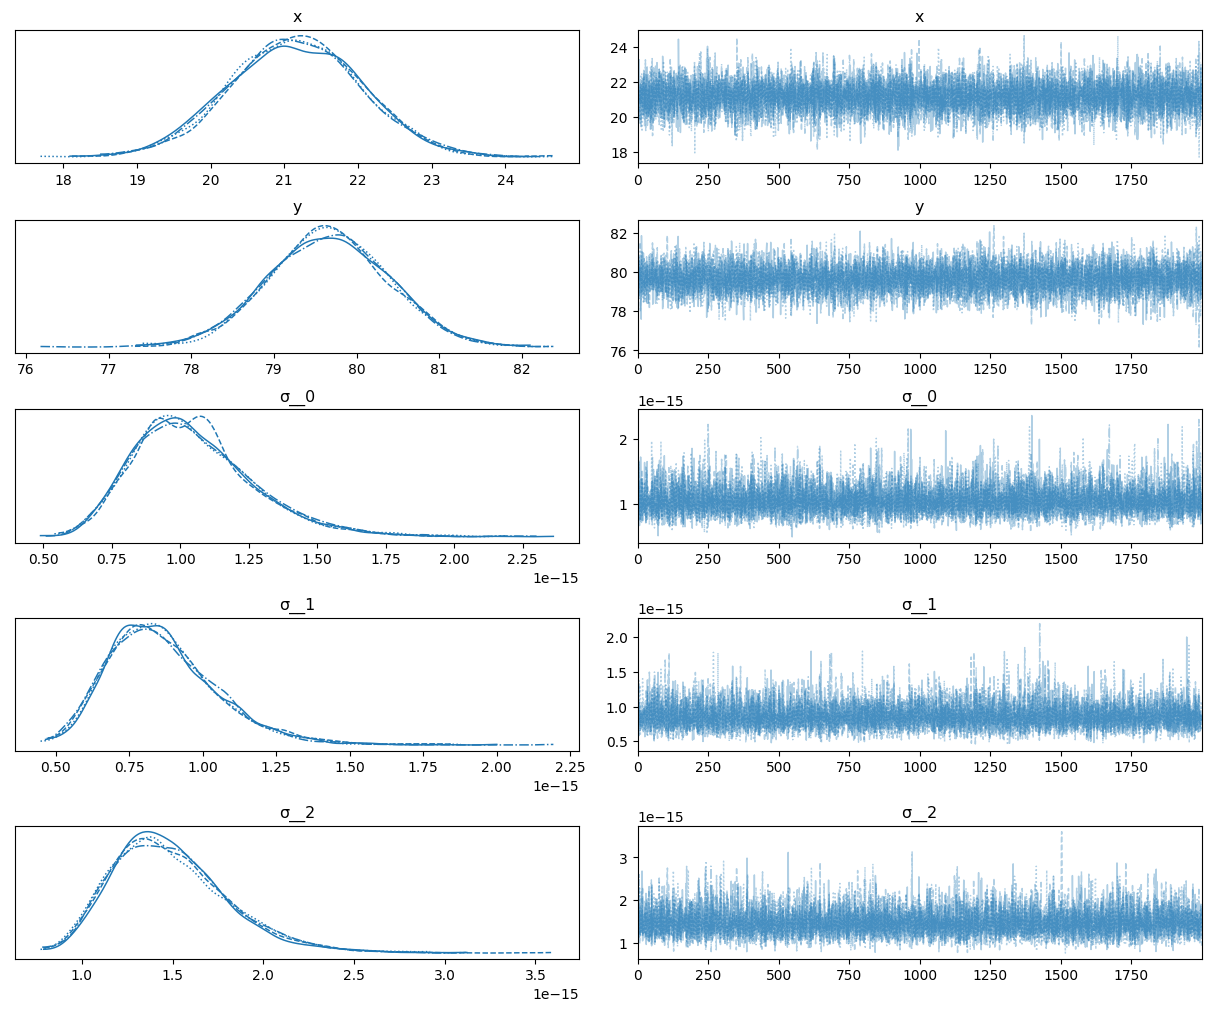

In [104]:
pm.traceplot(trace)
plt.show()

In [44]:
pm.summary(trace)

/home/hhilleshein/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x     19.998  1.033  18.089   21.968      0.010    0.007   10918.0    6406.0   
y     80.264  0.720  78.921   81.593      0.007    0.005   10786.0    6474.0   
σ__0   0.000  0.000   0.000    0.000      0.000    0.000   11356.0    6050.0   
σ__1   0.000  0.000   0.000    0.000      0.000    0.000   14826.0    6516.0   
σ__2   0.000  0.000   0.000    0.000      0.000    0.000   12901.0    6345.0   

      r_hat  
x       1.0  
y       1.0  
σ__0    1.0  
σ__1    1.0  
σ__2    1.0

## Seaborn plots
---

In [105]:
x_samples = trace['x']
y_samples = trace['y']

In [106]:
scenario_fiename = 'rss'
metric_filename = '_kde'
sampler_fiename = '_hmc'
base_filename = '_m' + str(sample_sz) + '_d' + str(n_draws) + '_j' + str(n_jobs) + '_c' + str(n_cores) + '_e' + str(100*delta)
scenario_fiename + sampler_fiename + metric_filename + base_filename

'rss_hmc_kde_m50_d2000_j4_c4_e1.1111111111111112e-13'

In [107]:
out_filename = './fig/' + scenario_fiename + sampler_fiename + metric_filename + base_filename + '.out'
out_filename

'./fig/rss_hmc_kde_m50_d2000_j4_c4_e1.1111111111111112e-13.out'

In [108]:
np.savetxt(out_filename, np.c_[x_samples, y_samples])

In [109]:
true_x, true_y = target_vt[0, 0], target_vt[0, 1]
true_x, true_y

(20, 80)

In [110]:
np.sqrt(np.mean(x_samples - true_x)**2)

In [111]:
np.sqrt(np.mean(y_samples - true_y)**2)

In [112]:
import seaborn as sns; sns.set(color_codes=True)

/home/hhilleshein/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


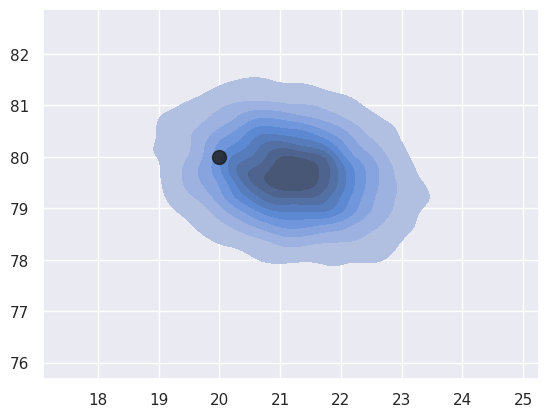

In [113]:
ax = sns.kdeplot(x_samples, y_samples, shade=True)
sns.regplot(x=np.array([true_x]), y=np.array([true_y]), scatter=True, fit_reg=False, marker='o', color = 'k',
            scatter_kws={"s": 100})
plt.show()

/home/hhilleshein/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


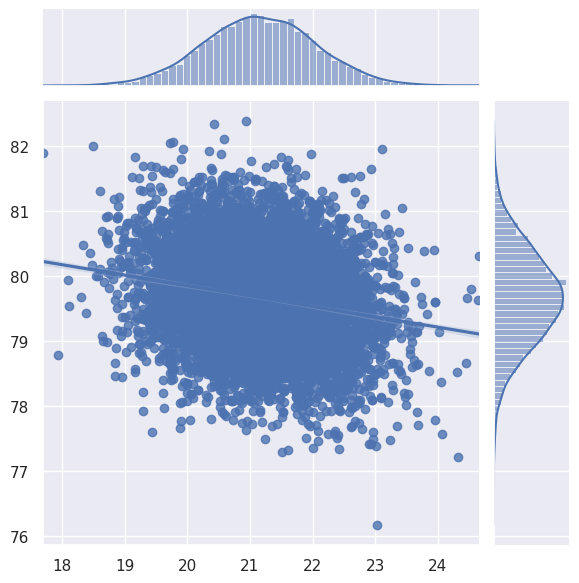

In [114]:
ax = sns.jointplot(x_samples, y_samples, color="b", kind="reg")
plt.show()

In [115]:
scenario_fiename = 'rss'
metric_filename = '_kde'
sampler_fiename = '_hmc'
base_filename = '_m' + str(sample_sz) + '_d' + str(n_draws) + '_j' + str(n_jobs) + '_c' + str(n_cores) + '_e' + str(100*delta)
scenario_fiename + sampler_fiename + metric_filename + base_filename

'rss_hmc_kde_m50_d2000_j4_c4_e1.1111111111111112e-13'

In [116]:
fig_filename = './fig/' + scenario_fiename + sampler_fiename + metric_filename + base_filename + '.pdf'
fig_filename

'./fig/rss_hmc_kde_m50_d2000_j4_c4_e1.1111111111111112e-13.pdf'

In [117]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

import matplotlib.pyplot as plt

plt.figure( figsize = (7.5, 7.5) )
fig = plt.gcf()

params = {'backend': 'pdf',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': True}
# plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update(params)

/home/hhilleshein/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hhilleshein/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 750x750 with 0 Axes>

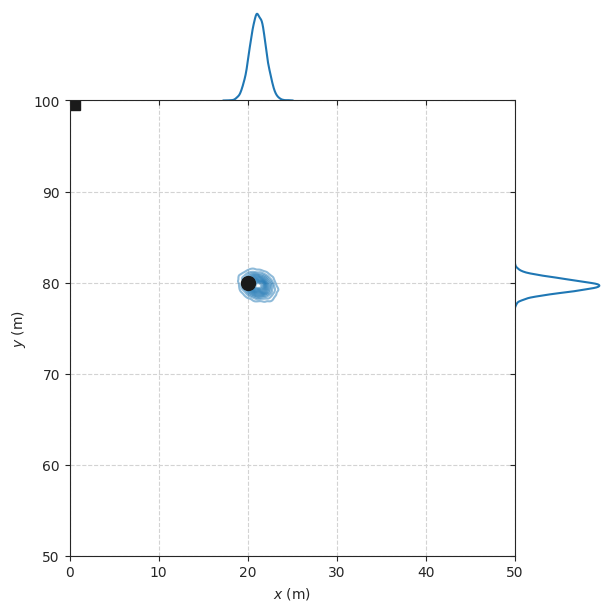

In [120]:
import matplotlib.pyplot as plt
plt.figure( figsize = (7.5, 7.5) )
sns.set_style("ticks")

ax = sns.jointplot(x_samples, y_samples, kind="kde", alpha=.5, n_levels = 15, \
                   xlim={0, 50}, ylim={50, 100}, \
                   space = 0, joint_kws=dict(shade_lowest=False)).set_axis_labels('$x$ (m)', '$y$ (m)')
ax.ax_joint.plot([target_vt[0, 0]], [target_vt[0, 1]], 'ko', markersize = 10)
ax.ax_joint.plot([0], [100], 'ks', markersize = 15)
ax.ax_joint.grid(ls='--', color='lightgray')
plt.savefig(fig_filename, bbox_inches = 'tight', pad_inches = .1)
plt.show()

In [172]:
from scipy import stats

def from_posterior(samples, param):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y, testval=np.mean(samples))

def from_posterior_2(samples): # For mixture prior
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated.dist(x, y, testval=np.mean(samples))

In [122]:
def take_hist(trace, min_value, max_value):
    hist, x = np.histogram(trace, range=(min_value,max_value), bins=50, density= True)
    pdf = hist
    pdf = savgol_filter(pdf, 11, 3) #Smoothing
    pdf = np.where(pdf<0, 0, pdf) 
    x = x[:-1]
    return x, pdf

In [123]:
def move_target(last_position, angle_rad, distance):
    distance_x = np.cos(angle_rad)*distance;
    distance_y = np.sin(angle_rad)*distance;
    next_position = np.array([[last_position[0][0]+distance_x,last_position[0][1]+distance_y]])
    return next_position


In [169]:
try:
    trace = traces[0]
except:
    pass
traces = [trace]

# The iterative method

In [170]:
percentage = np.array([0.8, 0.2]) # For mixture prior
sd_multi = 2; # For mixture and normal priors

In [168]:
import math

In [175]:
position = target_vt
number_of_iterations = 19;
radius = 10;
# Circle center is -45 degres from initial position
circle_center = np.array([[target_vt[0][0]+10*np.cos((1/4)*np.pi), target_vt[0][1]-10*np.cos((1/4)*np.pi)]]) 
angles = np.linspace(-(5/4)*np.pi + (2*np.pi)/number_of_iterations, (3/4)*np.pi, number_of_iterations); 
for it in range(number_of_iterations):
  # generate more data
    
    position = move_target(circle_center, angles[it], radius); 
    dl = find_ttdoa_distance(anchor_cnt, position); # For static target, comment this line
    # The error
    err = np.random.multivariate_normal(mean=np.zeros(anchor_cnt-1), cov=Omega, size=sample_sz)
    t_tdoa_hat = dl/((3*(10**8))) + err;

    #with pos_model:
    rep_model = pm.Model()
    with rep_model:
        ## Simply use the posterior as prior
        #x = from_posterior(trace['x'],'x')
        #y = from_posterior(trace['y'],'y')
        
        ## Normal distribution with the same mean than the Posterior distribution
        #x = pm.Bound(pm.Normal, lower=0.0, upper=L)("x",mu=np.mean(trace["x"]),sd=sd_multi*math.sqrt(np.var(trace["x"])))
        #y = pm.Bound(pm.Normal, lower=0.0, upper=B)("y",mu=np.mean(trace["y"]),sd=sd_multi*math.sqrt(np.var(trace["y"])))
        
        ## Prior distribution is a mix of the posterior with a Normal
        x = pm.Mixture('x', w=percentage, comp_dists=[pm.Normal.dist(mu = np.mean(trace['x']) , sd = sd_multi*math.sqrt(np.var(trace['x']))), from_posterior_2(trace['x'])], testval=np.mean(trace['x']))
        y = pm.Mixture('y', w=percentage, comp_dists=[pm.Normal.dist(mu = np.mean(trace['y']) , sd = sd_multi*math.sqrt(np.var(trace['y']))), from_posterior_2(trace['y'])], testval=np.mean(trace['y']))
        σ = [[] for i in range(anchor_cnt-1)]
        for i in range(0, anchor_cnt-1):
            σ[i] = pm.HalfNormal('σ__' + str(i), sd = 10)
        ϕ = tt.stack([x, y], axis = 1)
        d = [[] for i in range(anchor_cnt)]
        μ = [[] for i in range(anchor_cnt-1)]
        for i in range(0, anchor_cnt):
            d[i] = pm.Deterministic('d' + str(i) , t_euclidean_distance(anchor_vt[i], ϕ))
        for i in range(0, anchor_cnt-1):
            μ[i] = (d[i+1]-d[0])/(3*(10**8))
        μ_ = tt.stack(μ).T

        cov = tt.nlinalg.alloc_diag(σ)
        joint_obs = pm.MvNormal('joint', mu=μ_, cov=cov, observed=t_tdoa_hat)

        trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
                      chains = n_jobs, cores = n_cores, tune = n_tunes, random_seed=SEED.tolist())  
        traces.append(trace)

<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 73 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
<ipython-input-175-958b000b0ce0>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .9), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.


In [74]:
pm.traceplot(traces[19])

<ipython-input-74-ea48c4778ec4>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(traces[19])
/home/hhilleshein/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'σ__0'}>,
        <AxesSubplot:title={'center':'σ__0'}>],
       [<AxesSubplot:title={'center':'σ__1'}>,
        <AxesSubplot:title={'center':'σ__1'}>],
       [<AxesSubplot:title={'center':'σ__2'}>,
        <AxesSubplot:title={'center':'σ__2'}>],
       [<AxesSubplot:title={'center':'d0'}>,
        <AxesSubplot:title={'center':'d0'}>],
       [<AxesSubplot:title={'center':'d1'}>,
        <AxesSubplot:title={'center':'d1'}>],
       [<AxesSubplot:title={'center':'d2'}>,
        <AxesSubplot:title={'center':'d2'}>],
       [<AxesSubplot:title={'center':'d3'}>,
        <AxesSubplot:title={'center':'d3'}>]], dtype=object)

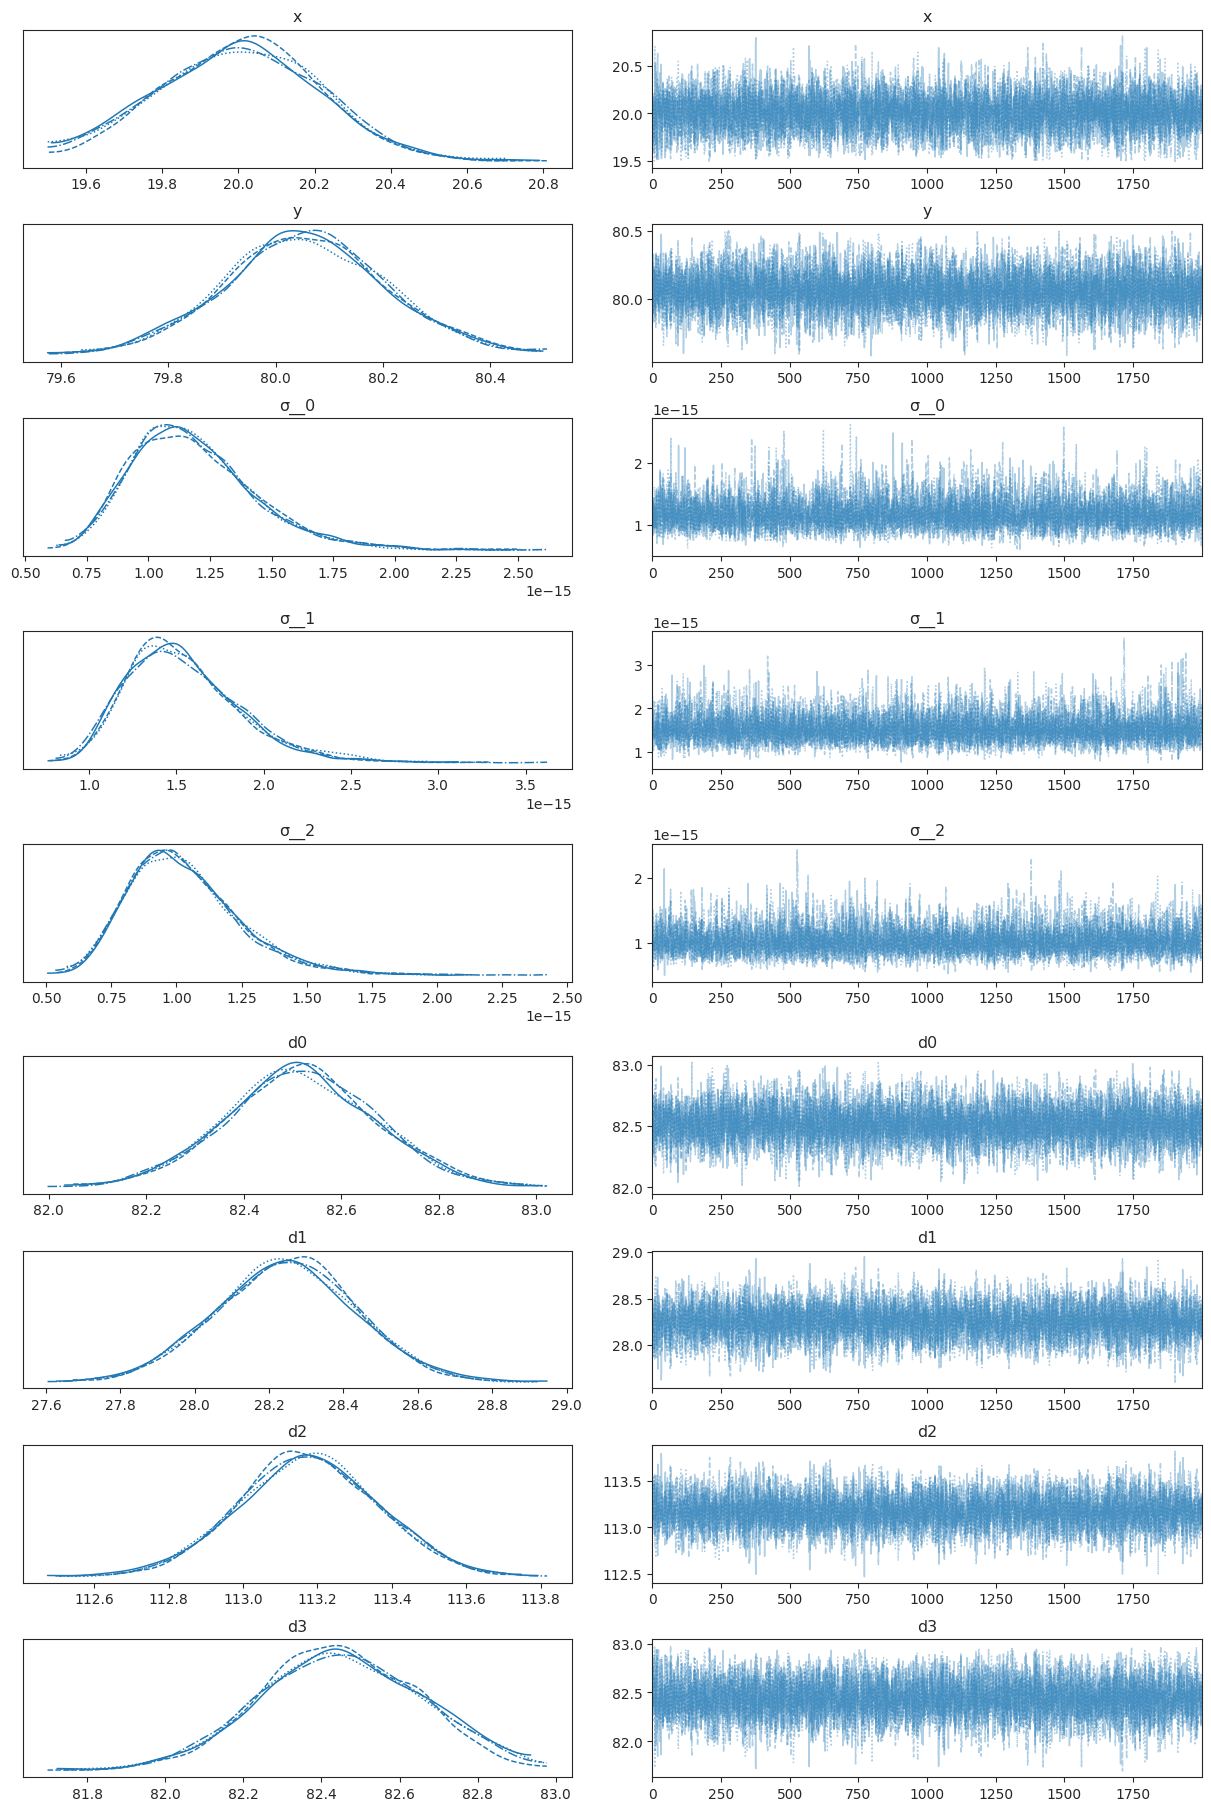

In [75]:
plt.show()

Posterior distributions after 20 iterations.


<Figure size 800x200 with 0 Axes>

<Figure size 800x200 with 0 Axes>

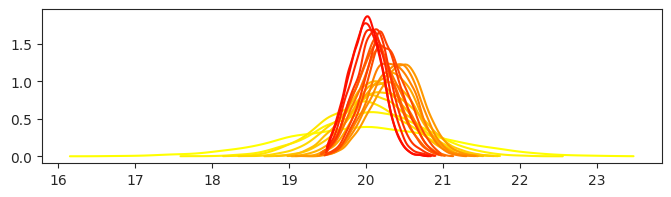

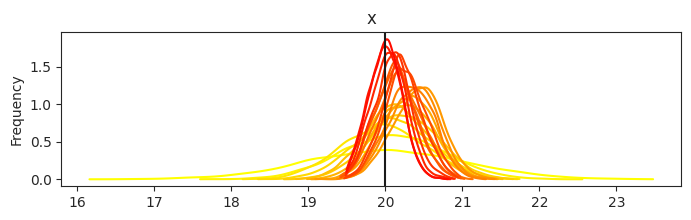

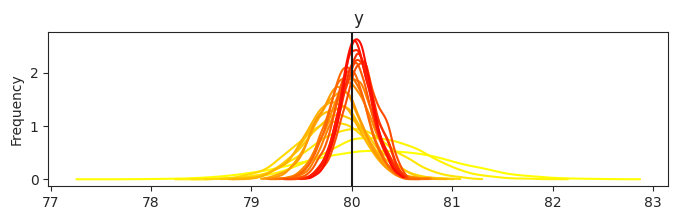

In [79]:
import matplotlib as mpl

print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
traced_itens = []
traced_itens.append('x')
traced_itens.append('y')
cmap = mpl.cm.autumn
for param in traced_itens:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces[:20]):
        #x, pdf = take_hist(trace[param])
        samples = trace[param] 
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples[:])(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'x': target_vt[0][0], 'y': target_vt[0][1]}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

In [81]:
[print("X mean " + str(i) + " = ", np.mean(traces[i]["x"]) ) for i in range(traces_num)]

X mean 0 =  19.997537230074972
X mean 1 =  20.090122819963266
X mean 2 =  19.984846701641967
X mean 3 =  20.107494014209397
X mean 4 =  20.246215730008362
X mean 5 =  20.129016874879532
X mean 6 =  20.23900713153095
X mean 7 =  20.28870329592002
X mean 8 =  20.4230907568379
X mean 9 =  20.366975168454438
X mean 10 =  20.319951119623017
X mean 11 =  20.18057969127954
X mean 12 =  20.13260592051115
X mean 13 =  20.131151979202667
X mean 14 =  20.260243618920093
X mean 15 =  20.212729526566427
X mean 16 =  20.098204279735313
X mean 17 =  20.04623958814316
X mean 18 =  19.995875015661987
X mean 19 =  20.00209130821193


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [138]:
[print("Y mean " + str(i) + " = ", np.mean(traces[i]["y"]) ) for i in range(traces_num)]

Y mean 0 =  80.19683327233767
Y mean 1 =  77.42221091621715
Y mean 2 =  73.94012633346487
Y mean 3 =  70.37644792753336
Y mean 4 =  67.93499777964158
Y mean 5 =  66.22413308968069
Y mean 6 =  63.30592754431734
Y mean 7 =  63.246267004022215
Y mean 8 =  63.989070493962814
Y mean 9 =  64.45113218186022
Y mean 10 =  65.89551797554866
Y mean 11 =  68.43834965410193
Y mean 12 =  70.40354599396832
Y mean 13 =  73.71274328440145
Y mean 14 =  77.85018532567886
Y mean 15 =  78.12411615881298
Y mean 16 =  81.42827084007236
Y mean 17 =  81.80814540480651
Y mean 18 =  82.76286534560043
Y mean 19 =  82.46200902912355
Y mean 20 =  81.51280891662222


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [82]:
[print("Y mean " + str(i) + " = ", np.var(traces[i]["y"]) ) for i in range(traces_num)]

Y mean 0 =  0.5178268348052824
Y mean 1 =  0.2489852410091902
Y mean 2 =  0.1734298749378408
Y mean 3 =  0.13390887508046087
Y mean 4 =  0.1082968527246228
Y mean 5 =  0.0844363309965101
Y mean 6 =  0.07483536063788232
Y mean 7 =  0.059604438918994244
Y mean 8 =  0.05207292806598956
Y mean 9 =  0.04952996361923907
Y mean 10 =  0.04335518828607063
Y mean 11 =  0.03965370768730442
Y mean 12 =  0.03521172784022176
Y mean 13 =  0.03361454697167749
Y mean 14 =  0.032429375255290965
Y mean 15 =  0.03200508317896458
Y mean 16 =  0.0290611638630247
Y mean 17 =  0.027601763562225868
Y mean 18 =  0.025465818886427058
Y mean 19 =  0.023369218002996184


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Plot Tracking

In [164]:
mean_x = np.zeros((len(traces),1))
mean_y = np.zeros((len(traces),1));
for idx in range(len(traces)): 
    mean_x[idx] = np.mean(traces[idx]['x'])
    mean_y[idx] = np.mean(traces[idx]['y'])

In [165]:
## Straight line
#real_path = np.linspace(20,40,21)
## Circle
real_path_angle = np.linspace(np.min(angles),np.max(angles), 1000);
real_path_angle = np.insert(real_path_angle, 0, (3/4)*np.pi, axis=0)
real_path_radius = radius;
real_path_circle_center = circle_center;
real_path = np.zeros((len(real_path_angle), 2));
actual_position = np.zeros((len(angles), 2));
for idx in range(len(real_path)):
    real_path[idx,:] = move_target(real_path_circle_center, real_path_angle[idx], real_path_radius);
for idx in range(len(angles)):
    actual_position[idx,:] = move_target(real_path_circle_center, angles[idx], real_path_radius);
real_path_x = real_path[:,0];
real_path_y = real_path[:,1];
actual_position_x = actual_position[:,0];
actual_position_y = actual_position[:,1];

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


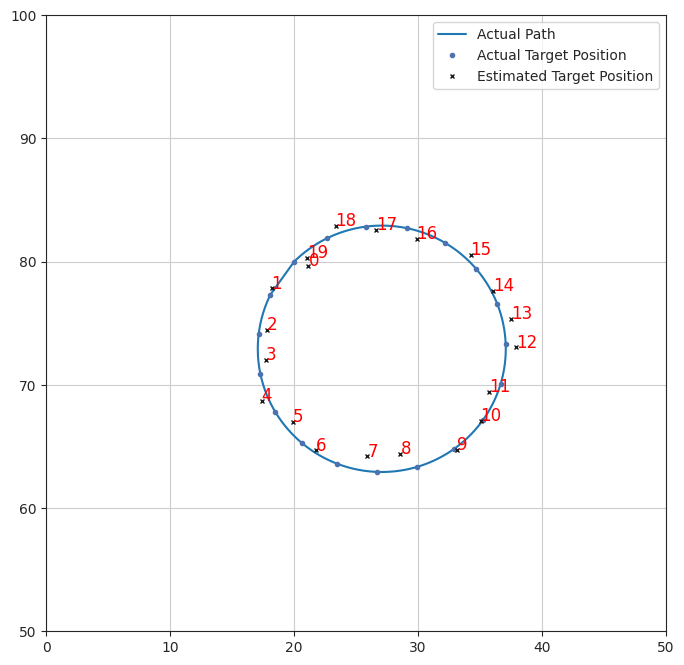

In [166]:
mean_x[:,0]
mean_y[:,0]
fig = plt.figure(figsize=(8, 8))
plt.plot(real_path_x,real_path_y, label = 'Actual Path') # Circle
plt.plot(actual_position_x,actual_position_y, 'ob', markersize=3, label = "Actual Target Position")
#plt.plot(mean_x_no_mix[:,0], mean_y_no_mix[:,0], 'xg', markersize=3, label = 'Estimated Target Position no mix')
plt.plot(mean_x[:,0], mean_y[:,0], 'xk', markersize=3, label = 'Estimated Target Position')
for idx in range(len(mean_x[:,0])):
    plt.text(mean_x[idx,0], mean_y[idx,0], str(idx), color="red", fontsize=12)
#    plt.text(mean_x_no_mix[idx,0], mean_y_no_mix[idx,0], str(idx), color="green", fontsize=12)
#plt.plot(20 + np.linspace(0,20,21)/np.sqrt(2), 80 - np.linspace(0,20,21)/np.sqrt(2)) # Straigth line
#plt.plot(np.linspace(20,40,21), np.repeat(80,21))
plt.ylim(50,100)
plt.xlim(0,50)
plt.grid()
plt.legend()
plt.savefig("./fig/circle_tracking.eps", dpi=600, facecolor=fig.get_facecolor(), bbox_inches = 'tight', pad_inches = .1, format='eps')
plt.show()

In [149]:
from math import sqrt
from sklearn.metrics import mean_squared_error
actual_position_x_mod = np.append(actual_position_x, actual_position_x[0])
rmse = sqrt(mean_squared_error(mean_x, actual_position_x_mod))
print(rmse)

3.3279514673301387


In [146]:
mean_x_no_mix = np.zeros((len(traces),1))
mean_y_no_mix = np.zeros((len(traces),1));
for idx in range(len(traces)): 
    mean_x_no_mix[idx] = np.mean(traces[idx]['x'])
    mean_y_no_mix[idx] = np.mean(traces[idx]['y'])

### Progress of Posterior for static targets

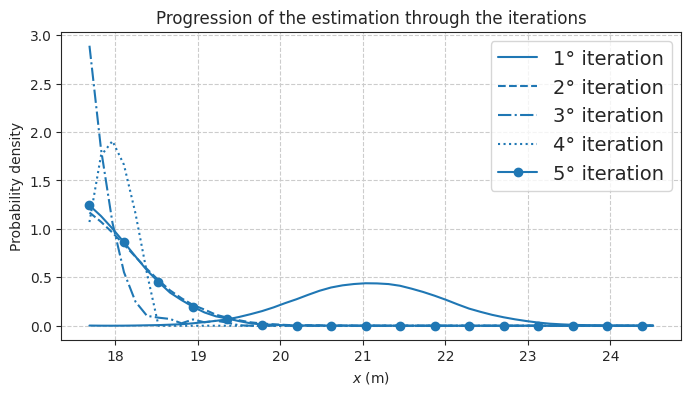

In [148]:
## For static targets
from scipy.signal import savgol_filter
x_samples = traces[0]['x']
min_value = min(x_samples)
max_value = max(x_samples)
from matplotlib.lines import Line2D
import matplotlib as mpl

styles = ['-', '--', '-.', ':', '-']
custom_lines = [Line2D([0], [0], linestyle=styles[0]),
                Line2D([0], [0], linestyle=styles[1]),
                Line2D([0], [0], linestyle=styles[2]),
                Line2D([0], [0], linestyle=styles[3]),
                Line2D([0], [0], linestyle='-', marker='o')]
#markers = ['-o', '-s', '-t', '-*', '-p']
fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
#cmap = mpl.cm.autumn
plt.xlabel('$x$ (m)')
plt.ylabel('Probability density')
for i in range(0,5):
    x_samples = traces[i]['x']
    #plt.hist(x_samples, bins='auto')
    x, pdf = take_hist(x_samples, min_value, max_value)
    plt.grid(ls='--')
    plt.plot(x,pdf, styles[i], color=custom_lines[i].get_color())
plt.plot(x[0:x.size:3],pdf[0:pdf.size:3] , 'o')
plt.title("Progression of the estimation through the iterations")
plt.legend(custom_lines, ['1° iteration','2° iteration','3° iteration','4° iteration','5° iteration'], prop={'size': 14})
plt.savefig("./fig/posteriors_x.png", dpi=600, facecolor=fig.get_facecolor(), bbox_inches = 'tight', pad_inches = .1)
plt.show()